In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 40))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/35 [00:00<?, ?it/s]

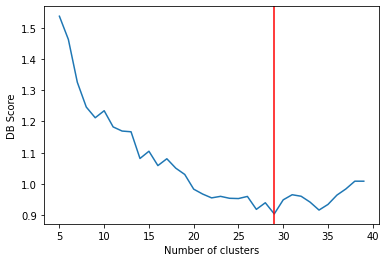

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

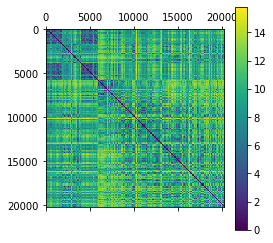

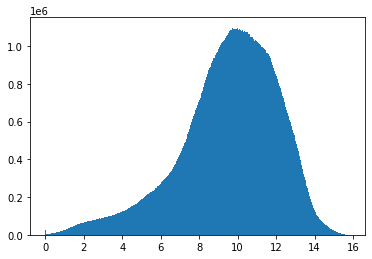

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

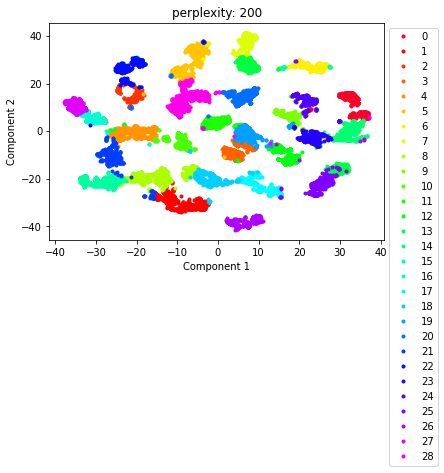

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9953678608387129


In [14]:
losses = []
accs = []
sparsity = []

In [ ]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09949878237171055
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7726174033149171
layer 6: 0.587189226519337
layer 7: 0.448118093922652
layer 8: 0.2781422651933702
layer 9: 0.14872885013812157
layer 10: 0.06277516401933701
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.375 | Reg loss: 0.021 | Tree loss: 3.375 | Accuracy: 0.046500 | 17.258 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.368 | Reg loss: 0.020 | Tree loss: 3.368 | Accuracy: 0.095000 | 16.227 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.364 | Reg loss: 0.020 | Tree loss: 3.364 | Accuracy: 0.102000 | 15.895 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.357 | Reg loss: 0.019 | Tree loss: 3.357 | Accuracy: 0.107500 | 15.471 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.355 | Reg loss: 0.019 | Tree loss: 3.355 | Accuracy: 0.108500 | 15.19 sec/iter
Epoch: 00 | Batch: 005 / 011 | 

Epoch: 04 | Batch: 008 / 011 | Total loss: 3.261 | Reg loss: 0.016 | Tree loss: 3.261 | Accuracy: 0.142500 | 15.481 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 3.245 | Reg loss: 0.016 | Tree loss: 3.245 | Accuracy: 0.153000 | 15.492 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 3.271 | Reg loss: 0.017 | Tree loss: 3.271 | Accuracy: 0.095563 | 15.336 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 3.350 | Reg loss: 0.015 | Tree loss: 3.350 | Accuracy: 0.189500 | 15.422 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.340 | Reg loss: 0.015 | Tree loss: 3.340 | Accuracy: 0.198000 | 15.438 sec/iter
Epoch: 05 | Batch: 002 / 01

Epoch: 09 | Batch: 005 / 011 | Total loss: 3.129 | Reg loss: 0.016 | Tree loss: 3.129 | Accuracy: 0.124500 | 15.292 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 3.097 | Reg loss: 0.017 | Tree loss: 3.097 | Accuracy: 0.119000 | 15.31 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 3.083 | Reg loss: 0.017 | Tree loss: 3.083 | Accuracy: 0.122000 | 15.321 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 3.072 | Reg loss: 0.017 | Tree loss: 3.072 | Accuracy: 0.122500 | 15.34 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 3.054 | Reg loss: 0.017 | Tree loss: 3.054 | Accuracy: 0.115000 | 15.353 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 3.013 | Reg loss: 0.017 | Tree loss: 3.013 | Accuracy: 0.119454 | 15.276 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375

Epoch: 14 | Batch: 002 / 011 | Total loss: 3.040 | Reg loss: 0.017 | Tree loss: 3.040 | Accuracy: 0.173500 | 15.46 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 2.986 | Reg loss: 0.018 | Tree loss: 2.986 | Accuracy: 0.164000 | 15.469 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 2.943 | Reg loss: 0.018 | Tree loss: 2.943 | Accuracy: 0.177500 | 15.466 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 2.914 | Reg loss: 0.018 | Tree loss: 2.914 | Accuracy: 0.177500 | 15.441 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 2.877 | Reg loss: 0.018 | Tree loss: 2.877 | Accuracy: 0.165500 | 15.448 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 2.843 | Reg loss: 0.018 | Tree loss: 2.843 | Accuracy: 0.183000 | 15.455 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 2.819 | Reg loss: 0.018 | Tree loss: 2.819 | Accuracy: 0.204000 | 15.461 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 2.801 | Reg loss: 0.018 | Tree loss: 2.801 | Accuracy: 0.228000 | 15.473 sec/iter
E

layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 2.918 | Reg loss: 0.019 | Tree loss: 2.918 | Accuracy: 0.182000 | 15.452 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 2.863 | Reg loss: 0.019 | Tree loss: 2.863 | Accuracy: 0.191000 | 15.457 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 2.824 | Reg loss: 0.019 | Tree loss: 2.824 | Accuracy: 0.200500 | 15.463 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 2.785 | Reg loss: 0.019 | Tree loss: 2.785 | Accuracy: 0.200000 | 15.47 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 2.729 | Reg loss: 0.019 | Tree loss: 2.729 | Accuracy: 0.211500 | 15.477 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 2.698 | Reg loss: 0.019 | Tree loss: 2.698 | Accuracy: 0.242000 | 15.459 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 2.668 | Reg loss: 0.019 | Tree loss: 2.668 | Accuracy: 0.256000 | 15.467 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 2.644 | Reg loss: 0.019 | Tree loss: 2.644 | Accuracy:

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 2.783 | Reg loss: 0.020 | Tree loss: 2.783 | Accuracy: 0.181000 | 15.498 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 2.760 | Reg loss: 0.020 | Tree loss: 2.760 | Accuracy: 0.191000 | 15.503 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 2.714 | Reg loss: 0.020 | Tree loss: 2.714 | Accuracy: 0.205500 | 15.507 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 2.639 | Reg loss: 0.020 | Tree loss: 2.639 | Accuracy: 0.218500 | 15.507 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 2.591 | Reg loss: 0.020 | Tree loss: 2.591 | Accuracy: 0.259500 | 15.505 sec/iter
Epoch: 24 | Batch: 005 / 01

Epoch: 28 | Batch: 008 / 011 | Total loss: 2.412 | Reg loss: 0.021 | Tree loss: 2.412 | Accuracy: 0.297000 | 15.488 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 2.392 | Reg loss: 0.022 | Tree loss: 2.392 | Accuracy: 0.306000 | 15.49 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 2.385 | Reg loss: 0.022 | Tree loss: 2.385 | Accuracy: 0.324232 | 15.455 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 2.674 | Reg loss: 0.021 | Tree loss: 2.674 | Accuracy: 0.210500 | 15.49 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 2.641 | Reg loss: 0.021 | Tree loss: 2.641 | Accuracy: 0.223500 | 15.49 sec/iter
Epoch: 29 | Batch: 002 / 011 |

Epoch: 33 | Batch: 005 / 011 | Total loss: 2.379 | Reg loss: 0.022 | Tree loss: 2.379 | Accuracy: 0.318000 | 15.408 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 2.338 | Reg loss: 0.022 | Tree loss: 2.338 | Accuracy: 0.316500 | 15.411 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 2.330 | Reg loss: 0.022 | Tree loss: 2.330 | Accuracy: 0.309500 | 15.413 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 2.318 | Reg loss: 0.022 | Tree loss: 2.318 | Accuracy: 0.331000 | 15.415 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 2.329 | Reg loss: 0.023 | Tree loss: 2.329 | Accuracy: 0.290000 | 15.416 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 2.325 | Reg loss: 0.023 | Tree loss: 2.325 | Accuracy: 0.320819 | 15.387 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 38 | Batch: 002 / 011 | Total loss: 2.446 | Reg loss: 0.023 | Tree loss: 2.446 | Accuracy: 0.263000 | 15.292 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 2.406 | Reg loss: 0.023 | Tree loss: 2.406 | Accuracy: 0.282000 | 15.292 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 2.353 | Reg loss: 0.023 | Tree loss: 2.353 | Accuracy: 0.291000 | 15.292 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 2.288 | Reg loss: 0.023 | Tree loss: 2.288 | Accuracy: 0.343000 | 15.278 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 2.265 | Reg loss: 0.023 | Tree loss: 2.265 | Accuracy: 0.331500 | 15.278 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 2.259 | Reg loss: 0.023 | Tree loss: 2.259 | Accuracy: 0.328000 | 15.278 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 2.258 | Reg loss: 0.023 | Tree loss: 2.258 | Accuracy: 0.327500 | 15.277 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 2.258 | Reg loss: 0.023 | Tree loss: 2.258 | Accuracy: 0.327500 | 15.277 sec/iter


Epoch: 43 | Batch: 000 / 011 | Total loss: 2.448 | Reg loss: 0.024 | Tree loss: 2.448 | Accuracy: 0.254500 | 15.242 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 2.439 | Reg loss: 0.024 | Tree loss: 2.439 | Accuracy: 0.251500 | 15.244 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 2.369 | Reg loss: 0.024 | Tree loss: 2.369 | Accuracy: 0.281000 | 15.244 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 2.326 | Reg loss: 0.024 | Tree loss: 2.326 | Accuracy: 0.299500 | 15.243 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 2.284 | Reg loss: 0.024 | Tree loss: 2.284 | Accuracy: 0.313000 | 15.241 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 2.254 | Reg loss: 0.024 | Tree loss: 2.254 | Accuracy: 0.326000 | 15.234 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 2.222 | Reg loss: 0.024 | Tree loss: 2.222 | Accuracy: 0.327500 | 15.238 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 2.195 | Reg loss: 0.024 | Tree loss: 2.195 | Accuracy: 0.342000 | 15.241 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 2.400 | Reg loss: 0.025 | Tree loss: 2.400 | Accuracy: 0.262500 | 15.253 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 2.353 | Reg loss: 0.025 | Tree loss: 2.353 | Accuracy: 0.274500 | 15.254 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 2.313 | Reg loss: 0.025 | Tree loss: 2.313 | Accuracy: 0.299500 | 15.256 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 2.268 | Reg loss: 0.025 | Tree loss: 2.268 | Accuracy: 0.330000 | 15.258 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 2.226 | Reg loss: 0.025 | Tree loss: 2.226 | Accuracy: 0.318500 | 15.261 sec/iter
Epoch: 48 | Batch: 005 / 01

Epoch: 52 | Batch: 008 / 011 | Total loss: 2.101 | Reg loss: 0.026 | Tree loss: 2.101 | Accuracy: 0.362500 | 15.262 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 2.100 | Reg loss: 0.026 | Tree loss: 2.100 | Accuracy: 0.340000 | 15.264 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 2.103 | Reg loss: 0.026 | Tree loss: 2.103 | Accuracy: 0.313993 | 15.249 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 2.378 | Reg loss: 0.025 | Tree loss: 2.378 | Accuracy: 0.270500 | 15.258 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 2.337 | Reg loss: 0.025 | Tree loss: 2.337 | Accuracy: 0.283500 | 15.261 sec/iter
Epoch: 53 | Batch: 002 / 01

Epoch: 57 | Batch: 005 / 011 | Total loss: 2.123 | Reg loss: 0.026 | Tree loss: 2.123 | Accuracy: 0.325000 | 15.271 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 2.109 | Reg loss: 0.026 | Tree loss: 2.109 | Accuracy: 0.334000 | 15.273 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 2.076 | Reg loss: 0.026 | Tree loss: 2.076 | Accuracy: 0.358000 | 15.276 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 2.068 | Reg loss: 0.026 | Tree loss: 2.068 | Accuracy: 0.361000 | 15.279 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 2.066 | Reg loss: 0.026 | Tree loss: 2.066 | Accuracy: 0.359000 | 15.282 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 2.071 | Reg loss: 0.026 | Tree loss: 2.071 | Accuracy: 0.348123 | 15.266 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 2.239 | Reg loss: 0.026 | Tree loss: 2.239 | Accuracy: 0.293500 | 15.293 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 2.179 | Reg loss: 0.026 | Tree loss: 2.179 | Accuracy: 0.316000 | 15.295 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 2.138 | Reg loss: 0.027 | Tree loss: 2.138 | Accuracy: 0.325000 | 15.297 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 2.108 | Reg loss: 0.027 | Tree loss: 2.108 | Accuracy: 0.301000 | 15.291 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 2.057 | Reg loss: 0.027 | Tree loss: 2.057 | Accuracy: 0.360000 | 15.294 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 2.080 | Reg loss: 0.027 | Tree loss: 2.080 | Accuracy: 0.348500 | 15.296 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 2.033 | Reg loss: 0.027 | Tree loss: 2.033 | Accuracy: 0.365500 | 15.298 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 2.035 | Reg loss: 0.027 | Tree loss: 2.035 | Accuracy: 0.358000 | 15.301 sec/iter


layer 10: 0.9723756906077345
Epoch: 67 | Batch: 000 / 011 | Total loss: 2.302 | Reg loss: 0.027 | Tree loss: 2.302 | Accuracy: 0.266000 | 15.307 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 2.229 | Reg loss: 0.027 | Tree loss: 2.229 | Accuracy: 0.300000 | 15.309 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 2.213 | Reg loss: 0.027 | Tree loss: 2.213 | Accuracy: 0.300000 | 15.311 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 2.155 | Reg loss: 0.027 | Tree loss: 2.155 | Accuracy: 0.301500 | 15.313 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 2.118 | Reg loss: 0.027 | Tree loss: 2.118 | Accuracy: 0.319500 | 15.316 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 2.079 | Reg loss: 0.027 | Tree loss: 2.079 | Accuracy: 0.337000 | 15.31 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 2.046 | Reg loss: 0.027 | Tree loss: 2.046 | Accuracy: 0.346500 | 15.312 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 2.038 | Reg loss: 0.027 | Tree loss: 2.038 | Accuracy:

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 2.281 | Reg loss: 0.027 | Tree loss: 2.281 | Accuracy: 0.284500 | 15.313 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 2.232 | Reg loss: 0.027 | Tree loss: 2.232 | Accuracy: 0.305500 | 15.314 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 2.185 | Reg loss: 0.027 | Tree loss: 2.185 | Accuracy: 0.306500 | 15.316 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 2.109 | Reg loss: 0.027 | Tree loss: 2.109 | Accuracy: 0.335000 | 15.318 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 2.092 | Reg loss: 0.027 | Tree loss: 2.092 | Accuracy: 0.319000 | 15.32 sec/iter
Epoch: 72 | Batch: 005 / 011

Epoch: 76 | Batch: 008 / 011 | Total loss: 2.010 | Reg loss: 0.028 | Tree loss: 2.010 | Accuracy: 0.353500 | 15.321 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 1.995 | Reg loss: 0.028 | Tree loss: 1.995 | Accuracy: 0.363000 | 15.323 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 1.948 | Reg loss: 0.028 | Tree loss: 1.948 | Accuracy: 0.348123 | 15.312 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 2.269 | Reg loss: 0.028 | Tree loss: 2.269 | Accuracy: 0.281000 | 15.32 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 2.230 | Reg loss: 0.028 | Tree loss: 2.230 | Accuracy: 0.301000 | 15.32 sec/iter
Epoch: 77 | Batch: 002 / 011 

Epoch: 81 | Batch: 005 / 011 | Total loss: 2.056 | Reg loss: 0.028 | Tree loss: 2.056 | Accuracy: 0.327500 | 15.413 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 2.013 | Reg loss: 0.028 | Tree loss: 2.013 | Accuracy: 0.348500 | 15.413 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 1.998 | Reg loss: 0.028 | Tree loss: 1.998 | Accuracy: 0.359500 | 15.421 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 2.008 | Reg loss: 0.028 | Tree loss: 2.008 | Accuracy: 0.337000 | 15.429 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 1.998 | Reg loss: 0.028 | Tree loss: 1.998 | Accuracy: 0.362500 | 15.437 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 1.979 | Reg loss: 0.028 | Tree loss: 1.979 | Accuracy: 0.313993 | 15.426 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 86 | Batch: 002 / 011 | Total loss: 2.149 | Reg loss: 0.028 | Tree loss: 2.149 | Accuracy: 0.319500 | 15.672 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 2.087 | Reg loss: 0.028 | Tree loss: 2.087 | Accuracy: 0.344500 | 15.671 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 2.070 | Reg loss: 0.028 | Tree loss: 2.070 | Accuracy: 0.323000 | 15.678 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 2.057 | Reg loss: 0.028 | Tree loss: 2.057 | Accuracy: 0.326000 | 15.684 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 1.988 | Reg loss: 0.028 | Tree loss: 1.988 | Accuracy: 0.354000 | 15.691 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 1.983 | Reg loss: 0.028 | Tree loss: 1.983 | Accuracy: 0.355500 | 15.697 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 2.010 | Reg loss: 0.028 | Tree loss: 2.010 | Accuracy: 0.357500 | 15.704 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 2.006 | Reg loss: 0.028 | Tree loss: 2.006 | Accuracy: 0.355000 | 15.706 sec/iter


Epoch: 91 | Batch: 000 / 011 | Total loss: 2.208 | Reg loss: 0.028 | Tree loss: 2.208 | Accuracy: 0.290000 | 15.885 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 2.174 | Reg loss: 0.028 | Tree loss: 2.174 | Accuracy: 0.297000 | 15.891 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 2.169 | Reg loss: 0.028 | Tree loss: 2.169 | Accuracy: 0.307500 | 15.897 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 2.118 | Reg loss: 0.028 | Tree loss: 2.118 | Accuracy: 0.313000 | 15.903 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 2.101 | Reg loss: 0.028 | Tree loss: 2.101 | Accuracy: 0.314500 | 15.909 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 2.024 | Reg loss: 0.028 | Tree loss: 2.024 | Accuracy: 0.359500 | 15.915 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 1.994 | Reg loss: 0.029 | Tree loss: 1.994 | Accuracy: 0.352500 | 15.921 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 2.008 | Reg loss: 0.029 | Tree loss: 2.008 | Accuracy: 0.350500 | 15.927 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 2.194 | Reg loss: 0.029 | Tree loss: 2.194 | Accuracy: 0.308500 | 16.246 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 2.227 | Reg loss: 0.029 | Tree loss: 2.227 | Accuracy: 0.278500 | 16.245 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 2.120 | Reg loss: 0.029 | Tree loss: 2.120 | Accuracy: 0.321500 | 16.243 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 2.099 | Reg loss: 0.029 | Tree loss: 2.099 | Accuracy: 0.321000 | 16.242 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 2.064 | Reg loss: 0.029 | Tree loss: 2.064 | Accuracy: 0.329000 | 16.242 sec/iter
Epoch: 96 | Batch: 005 / 01

Epoch: 100 | Batch: 008 / 011 | Total loss: 1.968 | Reg loss: 0.029 | Tree loss: 1.968 | Accuracy: 0.358000 | 16.411 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 1.973 | Reg loss: 0.029 | Tree loss: 1.973 | Accuracy: 0.353500 | 16.41 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 1.930 | Reg loss: 0.029 | Tree loss: 1.930 | Accuracy: 0.375427 | 16.399 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 2.220 | Reg loss: 0.029 | Tree loss: 2.220 | Accuracy: 0.290500 | 16.415 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 2.196 | Reg loss: 0.029 | Tree loss: 2.196 | Accuracy: 0.310000 | 16.42 sec/iter
Epoch: 101 | Batch: 002 

Epoch: 105 | Batch: 005 / 011 | Total loss: 2.011 | Reg loss: 0.029 | Tree loss: 2.011 | Accuracy: 0.349000 | 16.55 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 2.016 | Reg loss: 0.029 | Tree loss: 2.016 | Accuracy: 0.317500 | 16.548 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 1.971 | Reg loss: 0.029 | Tree loss: 1.971 | Accuracy: 0.353500 | 16.547 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 1.983 | Reg loss: 0.029 | Tree loss: 1.983 | Accuracy: 0.360500 | 16.545 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 1.942 | Reg loss: 0.029 | Tree loss: 1.942 | Accuracy: 0.369000 | 16.544 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 1.928 | Reg loss: 0.029 | Tree loss: 1.928 | Accuracy: 0.368601 | 16.533 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [ ]:
print(f"Number of patterns: {len(root.get_leaves())}")

In [ ]:
method = 'MLE'

In [ ]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [ ]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")